# Hedging as a FBSDE

Take the typical setup for continuous-time asset pricing and assume the following dynamics for a riskless asset (money market instrument or bond)
$$
d S_{t}^{0}=S_{t}^{0} r_{t} d t 
$$
and a risky asset
$$
d S_{t}= \mu_{t}(S_{t}) d t+\sigma_{t}(S_{t}) d W_{t} , 
$$
where $W$ is a standard Brownian motion defined on a probability space $(\Omega,F,P)$ and $P$ is said to be the ”objective” probability
measure. We want to hedge an option on the risky asset that pays at maturity $g(S_{T})$. <br>

Any portfolio in the riskless and risky asset can be represented by $V_{t}=\pi_{t}^{0}+\pi_{t} $
the sum of the amounts invested in the riskless and risky asset, respectively.
The dynamics of $V_{t}$ follow from the dynamics of the risky and riskless asset
$V_{t}$ is said to be self-financing if it satisfies the following linear SDE

$$
\begin{aligned} 
d V_{t} &= d\pi_{t}^{0}+d\pi_{t} \\
        &= \pi_{t}^{0} r_{t} dt +  \mu_{t}(\pi_{t}) dt + \sigma_{t}( \pi_{t}) dW_{t} \\
        &= (V_{t}- \pi_{t}) r_{t} dt +  \mu_{t}(\pi_{t}) dt + \sigma_{t}( \pi_{t}) dW_{t} \\
        &= (V_{t} r_{t} -\pi_{t}r_{t} + \mu_{t}(\pi_{t})) dt + \sigma_{t}(\pi_{t}) dW_{t} 
\end{aligned} 
$$
if there exist an $\pi_{t}$ $F_{t}$-adapted such that $ \forall \omega \in \Omega :V_{T}(\omega) = g(S_{T})(\omega)$ we call 
$V_{t}$ the replicating portfolio of the option and the fair price for the option is $V_{0}$.  <br>
I.e. we can formulate hedging a option as finding a solution $(S_{t},V_{t},\pi_{t})$ $F_{t}$-adapted such that:

$$
\begin{aligned}
d S_{t}&= \mu_{t}(S_{t}) d t+\sigma_{t}(S_{t}) d W_{t} \\
d V_{t}&= (V_{t} r_{t} -\pi_{t}r_{t} + \mu_{t}(\pi_{t})) dt + \sigma_{t}(\pi_{t}) dW_{t} \\
\forall \omega &\in \Omega :V_{T}(\omega) = g(S_{T})(\omega), \\
S_{0}&=s_{0}
.
\end{aligned}
$$ 
These equations form a Forward Backward Stochastic Differential Equation (FBSDE) and have a unique
solution when conditions on $\mu, \sigma, r, g$ are met see THEOREM 7.1 Pardoux-Peng [170] (nonlinear option pricing book). <br>

A general form for a FBSDEs is the backward part:

$$
\left\{\begin{array} {l} {{{d Y_{t}=-f \left( t, X_{t}, Y_{t}, Z_{t} \right) d t+Z_{t} d W_{t}, \quad t \in\left[ 0, T \right]}}} \\ {{{Y_{T}=\Phi( X_{t} ),}}} \\ \end{array} \right. 
$$
The forward part:

$$
\left\{\begin{array} {l} {{d X_{t}=\mu( t, X_{t} ) d t+\sigma( t, X_{t} ) d W_{t}, \quad t \in[ 0, T ]}} \\ {{X_{0}=x.}} \\ \end{array} \right. 
$$
FBSDEs have a Feyman-Kac formula a relationship with nonlinear PDEs.


## Euler scheme 

The forward part can be approximated by discretizing time with time step $\Delta_{i}^{N}$ 
 so the forward SDE using an Euler scheme is:

$$
\left\{\begin{array} {l} {{X_{0}^{N}=X_{0}}} \\ {{X_{t_{i}}^{N}=X_{t_{i-1}}^{N}+\mu \left( t_{i-1}, X_{t_{i-1}}^{N} \right) \Delta_{i}^{N}+\sigma\left(t_{i-1}, X_{t_{i-1}}^{N} \right) \Delta W_{i}^{N}.}} \\ \end{array} \right. 
$$

Similarly the backward part can be time discretized:

$$
\begin{aligned}
    Y_{t_{i}}&=Y_{t_{i+1}}+\int_{t_{i}}^{t_{i+1}} f \left( s, X_{s}, Y_{s}, Z_{s} \right) d s-\int_{t_{i}}^{t_{i+1}} Z_{S} d W_{s} \\
Y^{N}_{t_{i}}&\approx Y_{t_{i+1}}^{N}+\Delta_{i}^{N} f \left( t_{i}, X_{t_{i}}^{N}, Y_{t_{i}}^{N}, Z_{t_{i}}^{N} \right)-\Delta W_{i}^{N} Z_{t_{i}}
.
\end{aligned}
$$ 

.


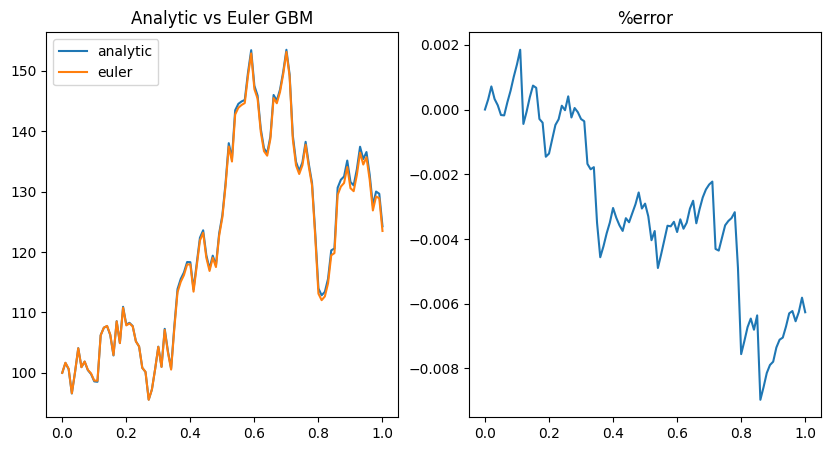

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_GBM_path(S0, mu, sigma, T, dt, num_paths):
    """Simulate multiple paths of the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    N = round(T/dt)
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size = (num_paths, N)) 
    W = np.insert(W, 0, 0, axis=1)
    W = np.cumsum(W, axis=1)*np.sqrt(dt) ### standard brownian motion
    X = (mu - 0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion
    return S

def euler_maruyama(X0, mu, sigma, T, N, num_paths):
    dt = T/N
    t = np.linspace(0, T, N+1)
    X = np.zeros((num_paths, N+1))
    X[:, 0] = X0
    for j in range(num_paths):
        for i in range(1, N+1):
            X[j, i] = X[j, i-1] + mu(t[i-1], X[j, i-1]) * dt + sigma(t[i-1],X[j, i-1]) * np.random.normal(0,np.sqrt(dt))
    return t, X

def muGBM(mu): return lambda t, X: mu*X
def sigmaGBM(sigma): return lambda t,X: sigma*X

from parameters import parameters_default
par = parameters_default()
par.N = 100
par.num_paths=1

seed = np.random.randint(0,100000)
np.random.seed(seed)

realization_euler_gbm = euler_maruyama(par.S0, muGBM(par.mu), sigmaGBM(par.sigma), par.T, par.N,par.num_paths)

np.random.seed(seed)
paths = simulate_GBM_path(par.S0, par.mu, par.sigma, par.T, par.T/par.N, par.num_paths)

fig, axs = plt.subplots(1,2,figsize=(10,5))

# First subplot
axs[0].plot(np.linspace(0,par.T,par.N+1), paths[0, :], label="analytic")
axs[0].plot(realization_euler_gbm[0], realization_euler_gbm[1][0,:], label="euler")
axs[0].legend()
axs[0].set_title('Analytic vs Euler GBM')

# Second subplot
axs[1].plot(realization_euler_gbm[0], (realization_euler_gbm[1][0,:]-paths[0,:])/(paths[0,:]+np.finfo(float).eps), label="euler")
axs[1].set_title('%error')

plt.show()

# Deep BSDE

[1] E, W., Han, J., and Jentzen, A. Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations, Communications in Mathematics and Statistics, 5, 349–380 (2017). <br>

In Hans' paper they propose formulating the FBSDE as an optimization problem by parameterizing $\pi_{t}$ or the control 
with a neural network. They use a subnetwork for each time step of the discretized Euler scheme we experimented with that
but didn't clean up that code. We chose for $1$ network approximating the control this makes it easier
to implement warm up procedures on coarser time discretizations. <br> 


This code is copied and heavily modified from:
https://github.com/YifanJiang233/Deep_BSDE_solver/tree/master.

The implementation is of following paper: 

https://arxiv.org/pdf/2101.01869.pdf

[2] Jiang,Y., Li, J. Convergence of the deep bsde method for fbsdes with non-lipschitz coefficients.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from parameterfree import COCOB
from dataclasses import dataclass
from typing import Callable,List
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@dataclass
class fbsde_parameters:
    S0: torch.Tensor
    mu: float 
    sigma: float # (b,x)
    f: Callable # (b,y)
    g: Callable # (b,x)
    T: float
    dim_x: int
    dim_y: int
    dim_W: int
    guess_sol: List[int]

    def __post_init__(self):
        self.S0 = self.S0.to(device)

#used to parameterize the control
class Network1(nn.Module):
    def __init__(self, fbsde_parameters, dim_h,num_layers):
        super(Network1, self).__init__()
        self.fbsde_parameters = fbsde_parameters

        # network parameters
        self.linear_first = nn.Linear(fbsde_parameters.dim_x+1, dim_h) # dim_x + 1  the extra 1 for time
        self.linear_inner = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(num_layers)])
        self.bn = nn.ModuleList([nn.BatchNorm1d(dim_h) for _ in range(num_layers)])
        self.linear_last = nn.Linear(dim_h, fbsde_parameters.dim_y*fbsde_parameters.dim_W)

    def get_z(self,x,t):
        # Concatenate the tensor 'x' and a tensor of ones multiplied by 't', along dimension 1
        output = torch.cat((x, t*torch.ones_like(x,device=device)), 1)
        output = F.gelu(self.linear_first(output))
        
        # Loop over each inner linear layer
        for i in range(len(self.linear_inner)):
            # Pass the output through the i-th inner linear layer, apply GELU activation function,
            # and add the result to the output tensor (this is a residual connection)
            output = output + self.bn[i](F.gelu(self.linear_inner[i](output)))

        return self.linear_last(output)


class Model(nn.Module):
    def __init__(self, fbsde_parameters, network):
        super(Model, self).__init__()
        self.fpar= fbsde_parameters
        self.net = network # implements self.get_z(x,t)

        # maybe should initialize y_0 outside?
        l = torch.rand(fbsde_parameters.dim_y, device=device)
        self.y_0 = nn.Parameter(fbsde_parameters.guess_sol[0]*l+ fbsde_parameters.guess_sol[1]*(1-l))



    def forward(self,batch_size, N):
        dt = torch.tensor(self.fpar.T / N)
        # initialize x and y, get them the right shape not sure if there is a better way
        x = self.fpar.S0+torch.zeros(batch_size,self.fpar.dim_x,device=device)
        y = self.y_0+torch.zeros(batch_size,self.fpar.dim_y,device=device)

        # forward simulation of both forward and backward SDEs
        for t in torch.linspace(0, self.fpar.T,N):
            z = self.net.get_z(x,t).reshape(batch_size,self.fpar.dim_y,self.fpar.dim_W)
            dW = torch.randn(batch_size, self.fpar.dim_W, device=device) * torch.sqrt(dt) 
            sig = self.fpar.sigma(t, x).reshape(batch_size,self.fpar.dim_x,self.fpar.dim_W)

            x = x+self.fpar.mu(t, x, y)*dt+ torch.einsum("bxw,bw->bx",sig, dW)
            y = y-self.fpar.f(t, x, y, z)*dt + torch.einsum("byw,bw->by",z, dW)
        return x, y



class BSDEsolver():
    def __init__(self, model):
        self.model = model 
        self.fpar = self.model.fpar

    def train(self, batch_size, N, itr, log):
        loss_fun = torch.nn.MSELoss().to(device)
        # optimizer = torch.optim.Adam(self.model.parameters()) didnt try to tune it
        optimizer = COCOB(self.model.parameters(),alpha= min(itr//2,100)) # alpha is warm up iterations
        loss_data, y0_data = [], []

        for i in range(itr):
            x, y = self.model(batch_size,N)
            loss = loss_fun(self.fpar.g(x), y)
            loss_data.append(float(loss))
            y0_data.append(float(self.model.y_0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if log  and i%int(itr/20) == 0:
                print(f"loss: {float(loss):7.2f} mean res: {torch.mean(self.fpar.g(x)-y):7.2f} y0: {float(self.model.y_0):7.2f} done: {i/itr*100:5.2f}% Iteration: {i}")
        return loss_data, y0_data

    def evaluate(self, batch_size, N):
        with torch.no_grad():
            x, y = self.model(batch_size, N)
            variance_hedged = torch.nn.MSELoss()(self.fpar.g(x), y)
            variance = torch.nn.MSELoss()(self.fpar.g(x), torch.zeros_like(x))
            residuals = y-self.fpar.g(x)
    
        residuals = residuals.detach().cpu() 
    
        for i in range(residuals.shape[1]):
            plt.figure(figsize=(10, 6))
            plt.hist(residuals[:, i], bins = batch_size//10)
            plt.title(f'Residuals for dimension {i+1}')
            plt.show()
    
        print(f"variance_hedged = {variance_hedged}, variance_option = {variance}, mean residual = {torch.mean(residuals)}")

In [41]:
import matplotlib.pyplot as plt
from parameters import parameters_default

par = parameters_default()

dim_x, dim_y, dim_W = 1, 1, 1
dim_h, num_layers = 10, 6

guess_sol = [0,27]

S0 = par.S0*torch.ones(dim_x)

def mu(t, x, y): return par.mu*x

def sigma(t, x): return par.sigma*x

def f_europian(t, x, y, z): return -par.r*y 

def g(x): return torch.max(par.K-x, torch.zeros_like(x, device=device)) 

torch.manual_seed(49)

fbsde_pars = fbsde_parameters(S0, mu, sigma, f_europian, g, par.T, dim_x, dim_y, dim_W, guess_sol)
net = Network1(fbsde_pars, dim_h, num_layers)
model = Model(fbsde_pars, net)
bsde_solver = BSDEsolver(model)


time_discretizations = [2,5,10,20,40]
iterations = [100,100,100,100,100]
batch_sizes = [100,100,1000,1000,1000]
# batch_sizes = 4*[10000] 

# time_discretizations = [2,5,10,20,40]
# iterations = [20,20,20,20,100]
# batch_sizes = [1000,1000,1000,1000,1000]
plotting = False

for N,it,batch_size in zip(time_discretizations,iterations,batch_sizes): 
    print(f"Time discretization: {N} Batch size: {batch_size} Iterations: {it}")
    loss, y0=bsde_solver.train(batch_size, N,it, log=True)
    print(60*"=")
    if plotting:
        fig, axs = plt.subplots(1,2)
        axs[0].plot(loss)
        axs[0].set_title('Loss')

        axs[1].plot(y0)
        axs[1].set_title('y0')

        plt.tight_layout()
        plt.show()

Time discretization: 2 Batch size: 100 Iterations: 100
loss: 2619.57 mean res:    4.25 y0:    5.62 done:  0.00% Iteration: 0
loss: 1316.43 mean res:    7.33 y0:    5.70 done:  5.00% Iteration: 5
loss:  752.65 mean res:    9.83 y0:    5.88 done: 10.00% Iteration: 10
loss:  282.14 mean res:   10.03 y0:    6.26 done: 15.00% Iteration: 15
loss:  114.80 mean res:    7.61 y0:    7.14 done: 20.00% Iteration: 20
loss:   90.22 mean res:    4.51 y0:    9.01 done: 25.00% Iteration: 25
loss:   64.97 mean res:    2.32 y0:   11.50 done: 30.00% Iteration: 30
loss:   43.62 mean res:    0.54 y0:   12.70 done: 35.00% Iteration: 35
loss:   48.17 mean res:    0.38 y0:   13.45 done: 40.00% Iteration: 40
loss:   47.64 mean res:   -1.21 y0:   13.51 done: 45.00% Iteration: 45
loss:   58.63 mean res:    0.63 y0:   13.95 done: 50.00% Iteration: 50
loss:   87.25 mean res:    0.90 y0:   13.66 done: 55.00% Iteration: 55
loss:   64.34 mean res:   -0.92 y0:   13.56 done: 60.00% Iteration: 60
loss:   60.52 mean res: 

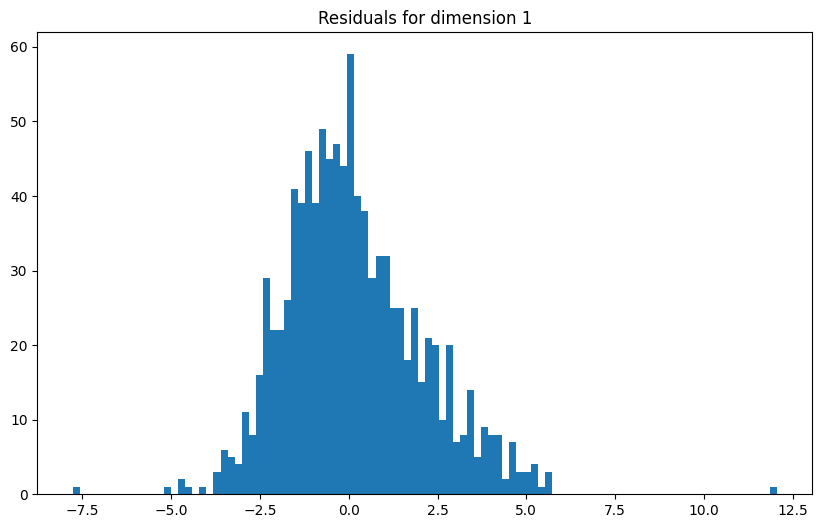

variance_hedged = 3.666977882385254, variance_option = 496.1549987792969, mean residual = 0.13564617931842804


In [42]:
bsde_solver.evaluate(1000, 1000)

# Deep BSDE for American Options
There are various ways to solve American options we did some reading see ./bibliograpy.bib file
and American options are related to reflected BSDEs (RBSDEs) not sure that there exist a Deep BSDE
solver for that. In some special cases the RBSDE can be parially solved leaving a BSDE (see The Early Exercise Premium Representation for American Options on Multiply Assets). Most deep BSDE approaches suitable for American option pricing solve 
backward in time unlike the deep BSDE method implemented in this notebook. <br>


## Chosen implementation
The code maintenance of the implementations of solvers we tried was poor, most code didn't run or
took to long to do so. For the assignment we chose 
the solver from (Deep neural network framework based on backward stochastic differential equations for pricing and hedging American options in high dimensions).  <br>

We ran their code within a conda env (see env.yml for the export), python main.py>output.txt, which can be found at
./deep BSDE tests/Amer_Op_Neural_Net-master/ouput.txt. Pricing an American put with the default parameters from the other notebooks  gave results close to that from binomial_trees and the Longstaff_Schwarz algorithm. 

## Sketch of the algorithm
An American option can be approximated by a Bermudan option, between exercise
dates the continuation value of Bermudan option satisfy a BSDE. They propose 
to solve this BSDE by minimizing the residuals squared of a time discretized version. 
To increase computational efficiency they modify this basic version.


# Future Directions

Due to time constraints I couldn't:

- Test the implemented Deep BSDEs solver in higher dimensions.

- Get a more rigorous base of BSDEs, I would read Derivatives en Detemple - Nonlinear Option Pricing.pdf (see bib file).

- Do a in depth literature review, I'm not aware of all deep BSDE solvers and have no intuition what really works.

- Understand and implement DEEP PRIMAL-DUAL ALGORITHM FOR BSDES  (see bib file) and the dual algorithm for longstaff schwarz.

- Get more familiar with deep learning frameworks.

- Profiling and optimizing the code for speed, I have no idea where to compute gets spent. 